In [1]:
import pickle
import gzip
import numpy as np
import scipy
import pandas as pd
import keras
import keras.layers as layers
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from keras.layers import Input, LSTM, Dense, Lambda, Conv1D, Conv2D, AveragePooling2D, AveragePooling1D, Flatten, MaxPooling2D, MaxPooling1D, Dropout
from keras.models import Model
from keras.models import Sequential
from keras.utils import Sequence
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.utils.np_utils import to_categorical
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from keras.layers.normalization import BatchNormalization
from keras.optimizers import RMSprop
from keras.applications import imagenet_utils
from keras import backend as K
from time import time
from keras import losses
from sklearn.metrics import  roc_curve, roc_auc_score, classification_report, confusion_matrix, accuracy_score, mean_absolute_error
import glob
from PIL import Image
import h5py
import random
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA, KernelPCA
from sklearn.metrics import confusion_matrix
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import sklearn.gaussian_process as gp
import pandas as pd
import pickle
from joblib import dump, load
from sklearn.utils import shuffle
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
import warnings
warnings.filterwarnings('ignore')
!pip install silence_tensorflow
from silence_tensorflow import silence_tensorflow
silence_tensorflow()
import tensorflow as tf

  Created wheel for silence-tensorflow: filename=silence_tensorflow-1.1.1-cp36-none-any.whl size=3743 sha256=d9550cffce20a0cb952bd91ef08f76afbbf4c33a85a75f74148a53b7e8aaf95f
  Stored in directory: /root/.cache/pip/wheels/51/0b/35/cf3020764bee61daa81fa249df3a448e3806344a087fc12292
Successfully built silence-tensorflow


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Wed Jan  6 20:04:27 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    23W / 300W |      0MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
    !rm -R qmc qmc1
    !git clone https://github.com/fagonzalezo/qmc.git
    !mv qmc qmc1
    !mv qmc1/qmc .
else:
    import sys
    sys.path.insert(0, "../")

rm: cannot remove 'qmc': No such file or directory
rm: cannot remove 'qmc1': No such file or directory
Cloning into 'qmc'...
remote: Enumerating objects: 215, done.
remote: Total 215 (delta 0), reused 0 (delta 0), pack-reused 215
Receiving objects: 100% (215/215), 17.06 MiB | 12.77 MiB/s, done.
Resolving deltas: 100% (91/91), done.


In [6]:
import qmc.tf.layers as layers
import qmc.tf.models as models

In [ ]:
data = pd.read_csv('/content/drive/My Drive/Colab_Notebooks/ICML2021/autompg/data/auto.data', header = None, sep = ' ')
X = data.to_numpy()
y = X[:,-1]
X = X[:,0:-1]

In [ ]:
y.shape

(392,)

In [ ]:
X.shape

(392, 7)

Los labels van de 1 a 5

In [ ]:
print(max(y))
print(min(y))

5.0
1.0


In [ ]:
y = (y-1)/4
y = np.float64(y)
y = y.reshape((392,1))
X = np.float64(X)

Normalizando los datos:

In [ ]:
scaler = preprocessing.StandardScaler().fit(X)
X = scaler.transform(X)

In [ ]:
from scipy.spatial import distance

distances = distance.cdist(X, X, 'euclidean')

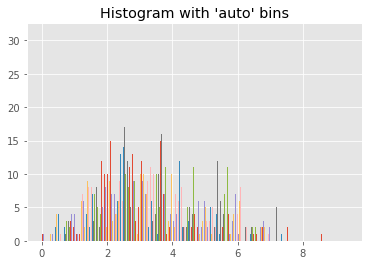

In [ ]:
import matplotlib.pyplot as plt

_ = plt.hist(distances, bins='auto')  # arguments are passed to np.histogram

plt.title("Histogram with 'auto' bins")

plt.show()

Sigma:

In [ ]:
print(np.mean(distances))
print(np.median(distances))

3.41515103326364
3.194522475547268


Gamma:

In [ ]:
print(1/(np.mean(distances)**2))
print(1/(np.median(distances)**2))

0.08573934673739754
0.09799143192472377


In [7]:
for i in range(10, 20):
    print('----------------------------------------',i+1)
    number = str(i+1)
    train_path = '/content/drive/My Drive/Colab_Notebooks/ICML2021/autompg/data/auto.data_train_5.'
    test_path = '/content/drive/My Drive/Colab_Notebooks/ICML2021/autompg/data/auto.data_test_5.'
    
    data = pd.read_csv(train_path+number, header = None, sep = ' ')
    X = data.to_numpy()
    y = X[:,-1]
    X = X[:,0:-1]

    y = (y-1)/4
    y = np.float64(y)
    y = y.reshape((200,1))
    X = np.float64(X)

    scaler = preprocessing.StandardScaler().fit(X)
    X = scaler.transform(X)

    X, y = shuffle(X, y, random_state=0)

    MAE_opt = 100
    dim_y = 5
    for j in range(25):

        beta = np.random.sample()*25
        gamma = np.random.sample()*0.1
        learning_rate = np.random.sample()*0.001
        alpha = np.random.sample()
        dim_x = 7+np.random.sample()*1000
        dim_x = int(dim_x)
        num_eig = np.random.choice([int(dim_x/2),int(dim_x/4),int(dim_x/8), int(dim_x/16)])
        num_eig = int(num_eig)

        print('------------', j+1, 'beta=', beta, 'gamma=', gamma, 'learning_rate=', learning_rate, 'alpha=', alpha, 'dim_x=', dim_x, 'num_eig=', num_eig)

        MAE = []

        fm_y = layers.QFeatureMapSmp(dim=dim_y, beta=beta)
        fm_x = layers.QFeatureMapRFF(7, dim=dim_x, gamma=gamma, random_state=1)
        qmr2 = models.QMRegressorSGD(input_dim=7, dim_x=dim_x, num_eig=num_eig, dim_y=dim_y, gamma=gamma, random_state=17)

        # for initialize weights

        qmr = models.QMRegressor(fm_x=fm_x, fm_y=fm_y, dim_x=dim_x, dim_y=dim_y)
        
        kf = KFold(n_splits=5)
            
        for train, test in kf.split(X):

            X_train = X[train]
            y_train = y[train]
            X_test = X[test]
            y_test = y[test]

            qmr.compile()
            qmr.fit(X_train, y_train, epochs=1, batch_size = 4, verbose = 0)

            qmr2.set_rho(qmr.get_rho())
            # Train model with SGD
            optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
            qmr2.layers[0].trainable = True

            def loss(y_true, y_pred):
                return tf.keras.losses.mean_squared_error(y_true, y_pred[:,0:1]) + alpha * y_pred[:, 1:2]

            qmr2.compile(optimizer, loss=loss)
            qmr2.set_rho(qmr.get_rho())
            early_stop = EarlyStopping( monitor="val_loss",
                                        min_delta=0,
                                        patience=5,
                                        verbose=0,
                                        mode="auto",
                                        restore_best_weights=True,
                                        )

            qmr2.fit(X_train, y_train, epochs=60, validation_split = 0.2, batch_size = 4, callbacks = early_stop, verbose=0)

            out = qmr2.predict(X_test, batch_size = 4)
            y_pred, std = out[:, 0], np.sqrt(out[:, 1])

            MAE.append(mean_absolute_error(np.rint(y_test*4)+1, np.rint(y_pred*4)+1))
        print('------mae = ',np.mean(MAE))

        if np.mean(MAE) < MAE_opt:
            MAE_opt = np.mean(MAE)
            beta_opt = beta
            gamma_opt = gamma
            learning_rate_opt = learning_rate
            alpha_opt = alpha
            dim_x_opt = dim_x   
            num_eig_opt = num_eig

    print('MAE = ',MAE_opt, 'beta = ',beta_opt, 'gamma = ', gamma_opt, 'learning_rate = ', learning_rate_opt, 'alpha = ', alpha_opt, 'dim_x = ', dim_x_opt, 'num_eig = ', num_eig_opt)

    X_train = X
    y_train = y

    X_test = pd.read_csv(test_path+number, header = None, sep = ' ')
    X_test = X_test.to_numpy()
    X_test = np.float64(X_test)
    y_test = X_test[:,-1]
    X_test = X_test[:,0:-1]
    X_test = scaler.transform(X_test)
    y_test = (y_test-1)/4
    y_test = np.float64(y_test)
    y_test = y_test.reshape((192,1))

    fm_y = layers.QFeatureMapSmp(dim=dim_y, beta=beta_opt)
    fm_x = layers.QFeatureMapRFF(7, dim=dim_x_opt, gamma=gamma_opt, random_state=1)
    qmr2 = models.QMRegressorSGD(input_dim=7, dim_x=dim_x_opt, num_eig=num_eig_opt, dim_y=dim_y, gamma=gamma_opt, random_state=17)

    # for initialize weights

    qmr = models.QMRegressor(fm_x=fm_x, fm_y=fm_y, dim_x=dim_x_opt, dim_y=dim_y)
    qmr.compile()
    qmr.fit(X_train, y_train, epochs=1, batch_size = 4)

    qmr2.set_rho(qmr.get_rho())
    # Train model with SGD
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate_opt)
    qmr2.layers[0].trainable = True

    def loss(y_true, y_pred):
        return tf.keras.losses.mean_squared_error(y_true, y_pred[:,0:1]) + alpha_opt * y_pred[:, 1:2]

    qmr2.compile(optimizer, loss=loss)
    qmr2.set_rho(qmr.get_rho())
    early_stop = EarlyStopping( monitor="val_loss",
                                min_delta=0,
                                patience=5,
                                verbose=0,
                                mode="auto",
                                restore_best_weights=True,
                                )

    qmr2.fit(X_train, y_train, epochs=100, validation_split = 0.2, batch_size = 4, callbacks = early_stop, verbose = 0)

    out = qmr2.predict(X_test, batch_size = 4)
    y_pred, std = out[:, 0], np.sqrt(out[:, 1])
    print('------------MAE =', mean_absolute_error(np.rint(y_test*4)+1, np.rint(y_pred*4)+1))

---------------------------------------- 11
------------ 1 beta= 21.504421563771743 gamma= 0.0577314151436997 learning_rate= 0.0007503717814694498 alpha= 0.9065387173193078 dim_x= 320 num_eig= 20
------mae =  0.26000000000000006
------------ 2 beta= 0.8739950360927229 gamma= 0.09237716360056951 learning_rate= 0.0004615410873215966 alpha= 0.00200887797382332 dim_x= 877 num_eig= 438
------mae =  0.24500000000000002
------------ 3 beta= 2.9667270145280753 gamma= 0.08323255472396018 learning_rate= 0.0003270739772579364 alpha= 0.19563665708101674 dim_x= 697 num_eig= 174
------mae =  0.23500000000000001
------------ 4 beta= 14.071708546547715 gamma= 0.010199215641891746 learning_rate= 0.000562074704820716 alpha= 0.7917010010069223 dim_x= 429 num_eig= 214
------mae =  0.285
------------ 5 beta= 12.369132593763752 gamma= 0.05788980036733449 learning_rate= 0.00037190570185712126 alpha= 0.4424805314392708 dim_x= 642 num_eig= 80
------mae =  0.26
------------ 6 beta= 16.452072789851847 gamma= 0.0

In [ ]:
for i in range(20):
    print('----------------------------------------',i+1)
    number = str(i+1)
    train_path = '/content/drive/My Drive/Colab_Notebooks/ICML2021/machine/data/machine_train_5.'
    test_path = '/content/drive/My Drive/Colab_Notebooks/ICML2021/machine/data/machine_test_5.'
    
    data = pd.read_csv(train_path+number, header = None, sep = ' ')
    X = data.to_numpy()
    y = X[:,-1]
    X = X[:,0:-1]

    y = (y-1)/4
    y = np.float64(y)
    y = y.reshape((150,1))
    X = np.float64(X)

    scaler = preprocessing.StandardScaler().fit(X)
    X = scaler.transform(X)

    X, y = shuffle(X, y, random_state=0)

    MAE_opt = 100
    dim_y = 5
    for j in range(1):

        beta = np.random.sample()*25
        gamma = np.random.sample()*0.01
        learning_rate = np.random.sample()*0.001
        alpha = np.random.sample()
        dim_x = 6+np.random.sample()*1000
        dim_x = int(dim_x)
        num_eig = np.random.choice([int(dim_x/2),int(dim_x/4),int(dim_x/8), int(dim_x/16)])
        num_eig = int(num_eig)

        print('------------', j+1, 'beta=', beta, 'gamma=', gamma, 'learning_rate=', learning_rate, 'alpha=', alpha, 'dim_x=', dim_x, 'num_eig=', num_eig)

        MAE = []

        fm_y = layers.QFeatureMapSmp(dim=dim_y, beta=beta)
        fm_x = layers.QFeatureMapRFF(6, dim=dim_x, gamma=gamma, random_state=1)
        qmr2 = models.QMRegressorSGD(input_dim=6, dim_x=dim_x, num_eig=num_eig, dim_y=dim_y, gamma=gamma, random_state=17)

        # for initialize weights

        qmr = models.QMRegressor(fm_x=fm_x, fm_y=fm_y, dim_x=dim_x, dim_y=dim_y)
        
        kf = KFold(n_splits=5)
            
        for train, test in kf.split(X):

            X_train = X[train]
            y_train = y[train]
            X_test = X[test]
            y_test = y[test]

            qmr.compile()
            qmr.fit(X_train, y_train, epochs=1, batch_size = 4, verbose = 0)

            qmr2.set_rho(qmr.get_rho())
            # Train model with SGD
            optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
            qmr2.layers[0].trainable = True

            def loss(y_true, y_pred):
                return tf.keras.losses.mean_squared_error(y_true, y_pred[:,0:1]) + alpha * y_pred[:, 1:2]

            qmr2.compile(optimizer, loss=loss)
            qmr2.set_rho(qmr.get_rho())
            early_stop = EarlyStopping( monitor="val_loss",
                                        min_delta=0,
                                        patience=5,
                                        verbose=0,
                                        mode="auto",
                                        restore_best_weights=True,
                                        )

            qmr2.fit(X_train, y_train, epochs=60, validation_split = 0.2, batch_size = 4, callbacks = early_stop, verbose=0)

            out = qmr2.predict(X_test, batch_size = 4)
            y_pred, std = out[:, 0], np.sqrt(out[:, 1])

            MAE.append(mean_absolute_error(np.rint(y_test*4)+1, np.rint(y_pred*4)+1))
        print('------mae = ',np.mean(MAE))

        if np.mean(MAE) < MAE_opt:
            MAE_opt = np.mean(MAE)
            beta_opt = beta
            gamma_opt = gamma
            learning_rate_opt = learning_rate
            alpha_opt = alpha
            dim_x_opt = dim_x   
            num_eig_opt = num_eig

    print('MAE = ',MAE_opt, 'beta = ',beta_opt, 'gamma = ', gamma_opt, 'learning_rate = ', learning_rate_opt, 'alpha = ', alpha_opt, 'dim_x = ', dim_x_opt, 'num_eig = ', num_eig_opt)

    X_train = X
    y_train = y

    X_test = pd.read_csv(test_path+number, header = None, sep = ' ')
    X_test = X_test.to_numpy()
    X_test = np.float64(X_test)
    y_test = X_test[:,-1]
    X_test = X_test[:,0:-1]
    X_test = scaler.transform(X_test)
    y_test = (y_test-1)/4
    y_test = np.float64(y_test)
    y_test = y_test.reshape((59,1))

    fm_y = layers.QFeatureMapSmp(dim=dim_y, beta=beta_opt)
    fm_x = layers.QFeatureMapRFF(6, dim=dim_x_opt, gamma=gamma_opt, random_state=1)
    qmr2 = models.QMRegressorSGD(input_dim=6, dim_x=dim_x_opt, num_eig=num_eig_opt, dim_y=dim_y, gamma=gamma_opt, random_state=17)

    # for initialize weights

    qmr = models.QMRegressor(fm_x=fm_x, fm_y=fm_y, dim_x=dim_x_opt, dim_y=dim_y)
    qmr.compile()
    qmr.fit(X_train, y_train, epochs=1, batch_size = 4)

    qmr2.set_rho(qmr.get_rho())
    # Train model with SGD
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate_opt)
    qmr2.layers[0].trainable = True

    def loss(y_true, y_pred):
        return tf.keras.losses.mean_squared_error(y_true, y_pred[:,0:1]) + alpha_opt * y_pred[:, 1:2]

    qmr2.compile(optimizer, loss=loss)
    qmr2.set_rho(qmr.get_rho())
    early_stop = EarlyStopping( monitor="val_loss",
                                min_delta=0,
                                patience=5,
                                verbose=0,
                                mode="auto",
                                restore_best_weights=True,
                                )

    qmr2.fit(X_train, y_train, epochs=100, validation_split = 0.2, batch_size = 4, callbacks = early_stop, verbose = 0)

    out = qmr2.predict(X_test, batch_size = 4)
    y_pred, std = out[:, 0], np.sqrt(out[:, 1])
    print('------------MAE =', mean_absolute_error(np.rint(y_test*4)+1, np.rint(y_pred*4)+1))

---------------------------------------- 1
------------ 1 beta= 18.140062800433224 gamma= 0.005117009867786848 learning_rate= 0.00030209680498659075 alpha= 0.4491953378373914 dim_x= 611 num_eig= 38
------mae =  0.24666666666666667
MAE =  0.24666666666666667 beta =  18.140062800433224 gamma =  0.005117009867786848 learning_rate =  0.00030209680498659075 alpha =  0.4491953378373914 dim_x =  611 num_eig =  38
38/38 [==============================] - 0s 1ms/step
------------MAE = 0.1694915254237288
---------------------------------------- 2
------------ 1 beta= 7.0377930558443325 gamma= 0.009139364388512426 learning_rate= 0.0008559031709118027 alpha= 0.09551361045186368 dim_x= 724 num_eig= 90
------mae =  0.15999999999999998
MAE =  0.15999999999999998 beta =  7.0377930558443325 gamma =  0.009139364388512426 learning_rate =  0.0008559031709118027 alpha =  0.09551361045186368 dim_x =  724 num_eig =  90
38/38 [==============================] - 0s 2ms/step
------------MAE = 0.23728813559322035

In [ ]:
for i in range(1):
    print('----------------------------------------',i+1)
    number = str(i+1)
    train_path = '/content/drive/My Drive/Colab_Notebooks/ICML2021/machine/data/machine_train_5.'
    test_path = '/content/drive/My Drive/Colab_Notebooks/ICML2021/machine/data/machine_test_5.'
    
    data = pd.read_csv(train_path+number, header = None, sep = ' ')
    X = data.to_numpy()
    y = X[:,-1]
    X = X[:,0:-1]

    y = (y-1)/4
    y = np.float64(y)
    y = y.reshape((150,1))
    X = np.float64(X)

    scaler = preprocessing.StandardScaler().fit(X)
    X = scaler.transform(X)

    X, y = shuffle(X, y, random_state=0)

    MAE_opt = 100
    dim_y = 5
    for j in range(100):

        beta = np.random.sample()*25
        gamma = np.random.sample()*0.1
        learning_rate = np.random.sample()*0.001
        alpha = np.random.sample()
        dim_x = 6+np.random.sample()*1000
        dim_x = int(dim_x)
        num_eig = np.random.choice([int(dim_x/2),int(dim_x/4),int(dim_x/8), int(dim_x/16)])
        num_eig = int(num_eig)

        print('------------', j+1, 'beta=', beta, 'gamma=', gamma, 'learning_rate=', learning_rate, 'alpha=', alpha, 'dim_x=', dim_x, 'num_eig=', num_eig)

        MAE = []

        fm_y = layers.QFeatureMapSmp(dim=dim_y, beta=beta)
        fm_x = layers.QFeatureMapRFF(6, dim=dim_x, gamma=gamma, random_state=1)
        qmr2 = models.QMRegressorSGD(input_dim=6, dim_x=dim_x, num_eig=num_eig, dim_y=dim_y, gamma=gamma, random_state=17)

        # for initialize weights

        qmr = models.QMRegressor(fm_x=fm_x, fm_y=fm_y, dim_x=dim_x, dim_y=dim_y)
        
        kf = KFold(n_splits=5)
            
        for train, test in kf.split(X):

            X_train = X[train]
            y_train = y[train]
            X_test = X[test]
            y_test = y[test]

            qmr.compile()
            qmr.fit(X_train, y_train, epochs=1, batch_size = 4, verbose = 0)

            qmr2.set_rho(qmr.get_rho())
            # Train model with SGD
            optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
            qmr2.layers[0].trainable = True

            def loss(y_true, y_pred):
                return tf.keras.losses.mean_squared_error(y_true, y_pred[:,0:1]) + alpha * y_pred[:, 1:2]

            qmr2.compile(optimizer, loss=loss)
            qmr2.set_rho(qmr.get_rho())
            early_stop = EarlyStopping( monitor="val_loss",
                                        min_delta=0,
                                        patience=5,
                                        verbose=0,
                                        mode="auto",
                                        restore_best_weights=True,
                                        )

            qmr2.fit(X_train, y_train, epochs=60, validation_split = 0.2, batch_size = 4, callbacks = early_stop, verbose=0)

            out = qmr2.predict(X_test, batch_size = 4)
            y_pred, std = out[:, 0], np.sqrt(out[:, 1])

            MAE.append(mean_absolute_error(np.rint(y_test*4)+1, np.rint(y_pred*4)+1))
        print('------mae = ',np.mean(MAE))

        if np.mean(MAE) < MAE_opt:
            MAE_opt = np.mean(MAE)
            beta_opt = beta
            gamma_opt = gamma
            learning_rate_opt = learning_rate
            alpha_opt = alpha
            dim_x_opt = dim_x   
            num_eig_opt = num_eig

    print('MAE = ',MAE_opt, 'beta = ',beta_opt, 'gamma = ', gamma_opt, 'learning_rate = ', learning_rate_opt, 'alpha = ', alpha_opt, 'dim_x = ', dim_x_opt, 'num_eig = ', num_eig_opt)

    X_train = X
    y_train = y

    X_test = pd.read_csv(test_path+number, header = None, sep = ' ')
    X_test = X_test.to_numpy()
    X_test = np.float64(X_test)
    y_test = X_test[:,-1]
    X_test = X_test[:,0:-1]
    X_test = scaler.transform(X_test)
    y_test = (y_test-1)/4
    y_test = np.float64(y_test)
    y_test = y_test.reshape((59,1))

    fm_y = layers.QFeatureMapSmp(dim=dim_y, beta=beta_opt)
    fm_x = layers.QFeatureMapRFF(6, dim=dim_x_opt, gamma=gamma_opt, random_state=1)
    qmr2 = models.QMRegressorSGD(input_dim=6, dim_x=dim_x_opt, num_eig=num_eig_opt, dim_y=dim_y, gamma=gamma_opt, random_state=17)

    # for initialize weights

    qmr = models.QMRegressor(fm_x=fm_x, fm_y=fm_y, dim_x=dim_x_opt, dim_y=dim_y)
    qmr.compile()
    qmr.fit(X_train, y_train, epochs=1, batch_size = 4)

    qmr2.set_rho(qmr.get_rho())
    # Train model with SGD
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate_opt)
    qmr2.layers[0].trainable = True

    def loss(y_true, y_pred):
        return tf.keras.losses.mean_squared_error(y_true, y_pred[:,0:1]) + alpha_opt * y_pred[:, 1:2]

    qmr2.compile(optimizer, loss=loss)
    qmr2.set_rho(qmr.get_rho())
    early_stop = EarlyStopping( monitor="val_loss",
                                min_delta=0,
                                patience=5,
                                verbose=0,
                                mode="auto",
                                restore_best_weights=True,
                                )

    qmr2.fit(X_train, y_train, epochs=100, validation_split = 0.2, batch_size = 4, callbacks = early_stop, verbose = 0)

    out = qmr2.predict(X_test, batch_size = 4)
    y_pred, std = out[:, 0], np.sqrt(out[:, 1])
    print('------------MAE =', mean_absolute_error(np.rint(y_test*4)+1, np.rint(y_pred*4)+1))

---------------------------------------- 1
------------ 1 beta= 11.234198850744326 gamma= 0.007333937783879552 learning_rate= 0.0005086776659105854 alpha= 0.49109620431457723 dim_x= 604 num_eig= 37
------mae =  0.26
------------ 2 beta= 19.68339853976282 gamma= 0.05317846844169576 learning_rate= 0.0003889307226053977 alpha= 0.3694178558707961 dim_x= 105 num_eig= 52
------mae =  0.25999999999999995
------------ 3 beta= 4.783784573831193 gamma= 0.04525559848242883 learning_rate= 0.0005077325332129377 alpha= 0.5000543686265224 dim_x= 890 num_eig= 111
------mae =  0.24
------------ 4 beta= 9.247523164684965 gamma= 0.08165367719894057 learning_rate= 0.00016678269216816843 alpha= 0.8074245341017605 dim_x= 671 num_eig= 41
------mae =  0.26
------------ 5 beta= 1.1738238536369932 gamma= 0.07882567351432462 learning_rate= 0.00011727526961380974 alpha= 0.07447097938816483 dim_x= 344 num_eig= 172
------mae =  0.24
------------ 6 beta= 17.509583793305023 gamma= 0.06397437629977214 learning_rate= 0

KeyboardInterrupt: ignored

In [ ]:
BIG_MAE=[]
for i in range(1):
    print('----------------------------------------',i+1)
    number = str(i+1)
    train_path = '/content/drive/My Drive/Colab_Notebooks/ICML2021/machine/data/machine_train_5.'
    test_path = '/content/drive/My Drive/Colab_Notebooks/ICML2021/machine/data/machine_test_5.'
    
    data = pd.read_csv(train_path+number, header = None, sep = ' ')
    X = data.to_numpy()
    y = X[:,-1]
    X = X[:,0:-1]

    y = (y-1)/4
    y = np.float64(y)
    y = y.reshape((150,1))
    X = np.float64(X)

    scaler = preprocessing.StandardScaler().fit(X)
    X = scaler.transform(X)

    MAE_opt = 100
    dim_y = 5
    for j in range(100):

        beta = np.random.sample()*25
        gamma = np.random.sample()*0.01
        learning_rate = np.random.sample()*0.001
        alpha = np.random.sample()
        dim_x = 6+np.random.sample()*1000
        dim_x = int(dim_x)
        num_eig = np.random.choice([int(dim_x/2),int(dim_x/4),int(dim_x/8), int(dim_x/16)])
        num_eig = int(num_eig)

        print('------------', j+1, 'beta=', beta, 'gamma=', gamma, 'learning_rate=', learning_rate, 'alpha=', alpha, 'dim_x=', dim_x, 'num_eig=', num_eig)

        MAE = []

        fm_y = layers.QFeatureMapSmp(dim=dim_y, beta=beta)
        fm_x = layers.QFeatureMapRFF(6, dim=dim_x, gamma=gamma, random_state=1)
        qmr2 = models.QMRegressorSGD(input_dim=6, dim_x=dim_x, num_eig=num_eig, dim_y=dim_y, gamma=gamma, random_state=17)

        # for initialize weights

        qmr = models.QMRegressor(fm_x=fm_x, fm_y=fm_y, dim_x=dim_x, dim_y=dim_y)
        
        kf = KFold(n_splits=5)
            
        for train, test in kf.split(X):

            X_train = X[train]
            y_train = y[train]
            X_test = X[test]
            y_test = y[test]

            qmr.compile()
            qmr.fit(X_train, y_train, epochs=1, batch_size = 4, verbose = 0)

            qmr2.set_rho(qmr.get_rho())
            # Train model with SGD
            optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
            qmr2.layers[0].trainable = True

            def loss(y_true, y_pred):
                return tf.keras.losses.mean_squared_error(y_true, y_pred[:,0:1]) + alpha * y_pred[:, 1:2]

            qmr2.compile(optimizer, loss=loss)
            qmr2.set_rho(qmr.get_rho())
            early_stop = EarlyStopping( monitor="val_loss",
                                        min_delta=0,
                                        patience=5,
                                        verbose=0,
                                        mode="auto",
                                        restore_best_weights=True,
                                        )

            qmr2.fit(X_train, y_train, epochs=60, validation_split = 0.2, batch_size = 4, callbacks = early_stop, verbose=0)

            out = qmr2.predict(X_test, batch_size = 4)
            y_pred, std = out[:, 0], np.sqrt(out[:, 1])

            MAE.append(mean_absolute_error(np.rint(y_test*4)+1, np.rint(y_pred*4)+1))
        print('------mae = ',np.mean(MAE))

        if np.mean(MAE) < MAE_opt:
            MAE_opt = np.mean(MAE)
            beta_opt = beta
            gamma_opt = gamma
            learning_rate_opt = learning_rate
            alpha_opt = alpha
            dim_x_opt = dim_x   
            num_eig_opt = num_eig

    print('MAE = ',MAE_opt, 'beta = ',beta_opt, 'gamma = ', gamma_opt, 'learning_rate = ', learning_rate_opt, 'alpha = ', alpha_opt, 'dim_x = ', dim_x_opt, 'num_eig = ', num_eig_opt)

    X_train = X
    y_train = y

    X_test = pd.read_csv(test_path+number, header = None, sep = ' ')
    X_test = X_test.to_numpy()
    X_test = np.float64(X_test)
    y_test = X_test[:,-1]
    X_test = X_test[:,0:-1]
    X_test = scaler.transform(X_test)
    y_test = (y_test-1)/4
    y_test = np.float64(y_test)
    y_test = y_test.reshape((59,1))

    fm_y = layers.QFeatureMapSmp(dim=dim_y, beta=beta_opt)
    fm_x = layers.QFeatureMapRFF(6, dim=dim_x_opt, gamma=gamma_opt, random_state=1)
    qmr2 = models.QMRegressorSGD(input_dim=6, dim_x=dim_x_opt, num_eig=num_eig_opt, dim_y=dim_y, gamma=gamma_opt, random_state=17)

    # for initialize weights

    qmr = models.QMRegressor(fm_x=fm_x, fm_y=fm_y, dim_x=dim_x_opt, dim_y=dim_y)
    qmr.compile()
    qmr.fit(X_train, y_train, epochs=1, batch_size = 4)

    qmr2.set_rho(qmr.get_rho())
    # Train model with SGD
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate_opt)
    qmr2.layers[0].trainable = True

    def loss(y_true, y_pred):
        return tf.keras.losses.mean_squared_error(y_true, y_pred[:,0:1]) + alpha_opt * y_pred[:, 1:2]

    qmr2.compile(optimizer, loss=loss)
    qmr2.set_rho(qmr.get_rho())
    early_stop = EarlyStopping( monitor="val_loss",
                                min_delta=0,
                                patience=5,
                                verbose=0,
                                mode="auto",
                                restore_best_weights=True,
                                )

    qmr2.fit(X_train, y_train, epochs=100, validation_split = 0.2, batch_size = 4, callbacks = early_stop, verbose = 0)

    out = qmr2.predict(X_test, batch_size = 4)
    y_pred, std = out[:, 0], np.sqrt(out[:, 1])
    print('------------MAE =', mean_absolute_error(np.rint(y_test*4)+1, np.rint(y_pred*4)+1))
    BIG_MAE.append(mean_absolute_error(np.rint(y_test*4)+1, np.rint(y_pred*4)+1))

---------------------------------------- 1
------------ 1 beta= 10.613181752177828 gamma= 0.006139004773313566 learning_rate= 0.00037250956342826935 alpha= 0.4263640035207138 dim_x= 242 num_eig= 15


KeyboardInterrupt: ignored

In [ ]:
y_pred

NameError: ignored

In [ ]:
BIG_MAE=[]
for i in range(8,10):
    print('----------------------------------------',i+1)
    number = str(i+1)
    train_path = '/content/drive/My Drive/Colab_Notebooks/ICML2021/machine/data/machine_train_5.'
    test_path = '/content/drive/My Drive/Colab_Notebooks/ICML2021/machine/data/machine_test_5.'
    
    data = pd.read_csv(train_path+number, header = None, sep = ' ')
    X = data.to_numpy()
    y = X[:,-1]
    X = X[:,0:-1]

    y = (y-1)/4
    y = np.float64(y)
    y = y.reshape((150,1))
    X = np.float64(X)

    scaler = preprocessing.StandardScaler().fit(X)
    X = scaler.transform(X)

    MAE_opt = 100
    dim_y = 5
    for j in range(25):

        beta = np.random.sample()*25
        gamma = np.random.sample()
        learning_rate = 0.000000099 + np.random.sample()*0.0009999
        alpha = np.random.sample()
        dim_x = 6+np.random.sample()*2000
        dim_x = int(dim_x)
        num_eig = np.random.choice([int(dim_x/8), int(dim_x/16), int(dim_x/32)])
        num_eig = int(num_eig)

        print('------------', j+1, 'beta=', beta, 'gamma=', gamma, 'learning_rate=', learning_rate, 'alpha=', alpha, 'dim_x=', dim_x, 'num_eig=', num_eig)

        MAE = []

        fm_y = layers.QFeatureMapSmp(dim=dim_y, beta=beta)
        fm_x = layers.QFeatureMapRFF(6, dim=dim_x, gamma=gamma, random_state=1)
        qmr2 = models.QMRegressorSGD(input_dim=6, dim_x=dim_x, num_eig=num_eig, dim_y=dim_y, gamma=gamma, random_state=17)

        # for initialize weights

        qmr = models.QMRegressor(fm_x=fm_x, fm_y=fm_y, dim_x=dim_x, dim_y=dim_y)
        
        kf = KFold(n_splits=5)
            
        for train, test in kf.split(X):

            X_train = X[train]
            y_train = y[train]
            X_test = X[test]
            y_test = y[test]

            qmr.compile()
            qmr.fit(X_train, y_train, epochs=1, batch_size = 4, verbose = 0)

            qmr2.set_rho(qmr.get_rho())
            # Train model with SGD
            optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
            qmr2.layers[0].trainable = True

            def loss(y_true, y_pred):
                return tf.keras.losses.mean_squared_error(y_true, y_pred[:,0:1]) + alpha * y_pred[:, 1:2]

            qmr2.compile(optimizer, loss=loss)
            qmr2.set_rho(qmr.get_rho())
            early_stop = EarlyStopping( monitor="val_loss",
                                        min_delta=0,
                                        patience=5,
                                        verbose=0,
                                        mode="auto",
                                        restore_best_weights=True,
                                        )

            qmr2.fit(X_train, y_train, epochs=60, validation_split = 0.2, batch_size = 4, callbacks = early_stop, verbose=0)

            out = qmr2.predict(X_test, batch_size = 4)
            y_pred, std = out[:, 0], np.sqrt(out[:, 1])

            MAE.append(mean_absolute_error(np.rint(y_test*4)+1, np.rint(y_pred*4)+1))

        if np.mean(MAE) < MAE_opt:
            MAE_opt = np.mean(MAE)
            beta_opt = beta
            gamma_opt = gamma
            learning_rate_opt = learning_rate
            alpha_opt = alpha
            dim_x_opt = dim_x   
            num_eig_opt = num_eig

    print('MAE = ',MAE_opt, 'beta = ',beta_opt, 'gamma = ', gamma_opt, 'learning_rate = ', learning_rate_opt, 'alpha = ', alpha_opt, 'dim_x = ', dim_x_opt, 'num_eig = ', num_eig_opt)

    X_train = X
    y_train = y

    X_test = pd.read_csv(test_path+number, header = None, sep = ' ')
    X_test = X_test.to_numpy()
    X_test = np.float64(X_test)
    y_test = X_test[:,-1]
    X_test = X_test[:,0:-1]
    X_test = scaler.transform(X_test)
    y_test = (y_test-1)/4
    y_test = np.float64(y_test)
    y_test = y_test.reshape((59,1))

    fm_y = layers.QFeatureMapSmp(dim=dim_y, beta=beta_opt)
    fm_x = layers.QFeatureMapRFF(6, dim=dim_x_opt, gamma=gamma_opt, random_state=1)
    qmr2 = models.QMRegressorSGD(input_dim=6, dim_x=dim_x_opt, num_eig=num_eig_opt, dim_y=dim_y, gamma=gamma_opt, random_state=17)

    # for initialize weights

    qmr = models.QMRegressor(fm_x=fm_x, fm_y=fm_y, dim_x=dim_x_opt, dim_y=dim_y)
    qmr.compile()
    qmr.fit(X_train, y_train, epochs=1, batch_size = 4)

    qmr2.set_rho(qmr.get_rho())
    # Train model with SGD
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate_opt)
    qmr2.layers[0].trainable = True

    def loss(y_true, y_pred):
        return tf.keras.losses.mean_squared_error(y_true, y_pred[:,0:1]) + alpha_opt * y_pred[:, 1:2]

    qmr2.compile(optimizer, loss=loss)
    qmr2.set_rho(qmr.get_rho())
    early_stop = EarlyStopping( monitor="val_loss",
                                min_delta=0,
                                patience=5,
                                verbose=0,
                                mode="auto",
                                restore_best_weights=True,
                                )

    qmr2.fit(X_train, y_train, epochs=100, validation_split = 0.2, batch_size = 4, callbacks = early_stop, verbose = 0)

    out = qmr2.predict(X_test, batch_size = 4)
    y_pred, std = out[:, 0], np.sqrt(out[:, 1])
    print('------------MAE =', mean_absolute_error(np.rint(y_test*4)+1, np.rint(y_pred*4)+1))
    BIG_MAE.append(mean_absolute_error(np.rint(y_test*4)+1, np.rint(y_pred*4)+1))

---------------------------------------- 9
------------ 1 beta= 14.274317272944076 gamma= 0.8786878337879533 learning_rate= 0.000761107385574344 alpha= 0.8060210000446789 dim_x= 1394 num_eig= 43
------------ 2 beta= 5.743602189505853 gamma= 0.2866947913351662 learning_rate= 0.0005560046318503614 alpha= 0.6879895555858141 dim_x= 1481 num_eig= 185
------------ 3 beta= 22.849283099852336 gamma= 0.7272643183935679 learning_rate= 0.0006730421975755477 alpha= 0.5574795248494053 dim_x= 1137 num_eig= 142
------------ 4 beta= 8.376209691710446 gamma= 0.7224771472605579 learning_rate= 0.000966447463715661 alpha= 0.6024299914567166 dim_x= 851 num_eig= 106
------------ 5 beta= 24.89130086615884 gamma= 0.5194781359584851 learning_rate= 0.00018291418695081377 alpha= 0.5809318839115516 dim_x= 846 num_eig= 105
------------ 6 beta= 23.016882865697237 gamma= 0.009603652659577966 learning_rate= 0.0008061441934469735 alpha= 0.30137685032402095 dim_x= 566 num_eig= 17
------------ 7 beta= 18.053825135460848